In [1]:
%pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 2041.3 MB 2.4 kB/s 
     |████████████████████████████████| 20.6 MB 20.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0
    Uninstalling torch-1.10.0:
      Successfully uninstalled torch-1.10.0
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu111/torch-1.9.1%2Bcu111-cp37-cp37m-linux_x86_64.whl (2041.3 MB)
  Using cached https://download.pytorch.org/whl/cu111/torchvision-0.10.1%2Bcu111-cp37-cp37m-linux_x86_64.whl (20.6 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages 

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

In [3]:
input_size = 784
num_classes = 10
batch_size = 256

train_dataset = dsets.CIFAR10(root='./CIFAR10/', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.CIFAR10(root='./CIFAR10/', 
                           train=False, 
                           transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,         
                                          shuffle=False)

Files already downloaded and verified


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, lin=0, lout=5):
        out = x
        if lin < 1 and lout > -1:
            out = self.conv1(out)
            out = self.bn1(out)
            out = F.relu(out)
        if lin < 2 and lout > 0:
            out = self.layer1(out)
        if lin < 3 and lout > 1:
            out = self.layer2(out)
        if lin < 4 and lout > 2:
            out = self.layer3(out)
        if lin < 5 and lout > 3:
            out = self.layer4(out)
        if lout > 4:
            out = F.avg_pool2d(out, 4)
            out = out.view(out.size(0), -1)
            out = self.linear(out)
        return out


def ResNet18():
    return ResNet(PreActBlock, [2,2,2,2])

In [25]:
def mixup(x, y, alpha=1.0, size=batch_size):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    size = min(size, x.size(0))
    batch_size = x.size()[0]
    index = torch.randperm(size)
    

    mixup_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixup_x, y_a, y_b, lam


def mixup_loss(criterion, pred, y_a, y_b, lam):
    return lam * criterion()(pred, y_a) + (1 - lam) * criterion()(pred, y_b)


In [66]:
#!g1.1
def cutmix(data, targets, alpha):
    data = data.clone()
    targets = targets.clone()
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)

    image_h, image_w = data.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]
    # targets = (targets, shuffled_targets, lam)
    return data, targets, targets, shuffled_targets, lam

def cutmix_loss(criterion, pred, y_a, y_b, lam):
    return lam * criterion()(pred, y_a) + (1 - lam) * criterion()(pred, y_b)

In [7]:
def cutout(data, targets, alpha):
    data = data.clone()
    targets = targets.clone()

    lam = np.random.beta(alpha, alpha)

    image_h, image_w = data.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    data[:, :, y0:y1, x0:x1] = 0
    # targets = (targets, shuffled_targets, lam)

    return data, targets

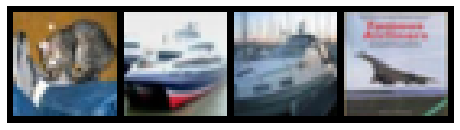

[3 8 8 0]


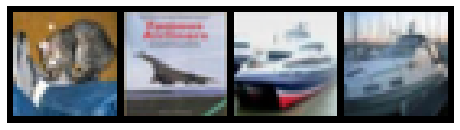

In [9]:
inputs, labels = iter(test_loader).next()
inputs = inputs[:4]
labels = labels[:4]

def imshow(images):
    img = images
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    plt.figure(figsize = (8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
imshow(inputs)
print(labels.numpy())

mixed, _, _, _ = mixup(inputs, labels, alpha=0.5, size=4)

imshow(mixed)

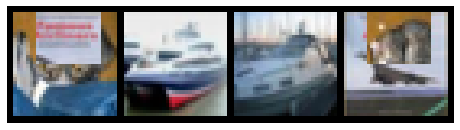

In [10]:
cutmixed, _ = cutmix(*(inputs, labels), alpha=0.5)
imshow(cutmixed)

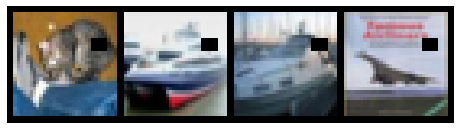

In [11]:
outmixed, _ = cutout(*(inputs, labels), alpha=0.5)
imshow(outmixed)

In [12]:
#!g1.1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [60]:
#!g1.1
from tqdm import trange

        
def train_epoch(model, optimizer, batchsize=32, use_mixup=True, alpha=0.5, use_cutmix=False, use_cutout=False):
    loss_log, acc_log = [], []
    model.train()
    for _, (x_batch, y_batch) in zip(trange(len(train_loader)), train_loader):
        data = x_batch
        target = y_batch
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)   
        if use_mixup:
            data, targets_a, targets_b, lam = mixup(data, target, alpha)
            data, targets_a, targets_b = map(Variable, (data,
                                                      targets_a, targets_b))
        elif use_cutmix:
            data, _, targets_a, targets_b, lam = cutmix(data, target, alpha)
        elif use_cutout:
            data, targets = cutout(data, target, alpha)
        
        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, target).float().mean()
        acc_log.append(acc)
        
        if use_mixup:
            loss = mixup_loss(nn.CrossEntropyLoss, output, targets_a, targets_b, lam)
        elif use_cutmix:
            loss = cutmix_loss(nn.CrossEntropyLoss, output, targets_a, targets_b, lam)
        elif use_cutout:
            loss = nn.CrossEntropyLoss()(output, target)
        else:
            loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):  
        data = x_batch
        target = y_batch
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        
        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, target).float().mean()
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs, use_mixup=True, alpha=0.5, use_cutmix=False, use_cutout=False):
    best_acc = 0
    best_wts = None
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch", epoch)
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize, use_mixup=use_mixup, alpha=alpha, use_cutmix=use_cutmix, use_cutout=use_cutout)

        val_loss, val_acc = test(model)
        mean_acc = torch.mean(torch.Tensor(val_acc))
        clear_output()
        print(f"Current cccuracy is {mean_acc}")
        if mean_acc > best_acc:
            print(f"Best accuracy now is {mean_acc}")
            best_acc = mean_acc
            best_wts = model.state_dict()
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(train_dataset.targets) / batch_size
        val_log.append((steps * (epoch + 1), torch.mean(torch.Tensor(val_loss)).float().cpu().numpy()))
        val_acc_log.append((steps * (epoch + 1), torch.mean(torch.Tensor(val_acc)).float().cpu().numpy()))

        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')   
    model.load_state_dict(best_wts)        
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))

# Train with no augmentation, with mixup, cutmix and cutout

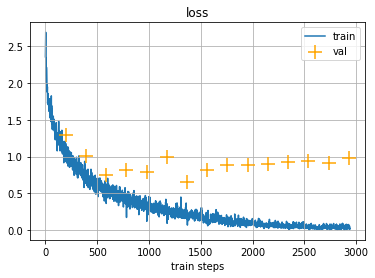

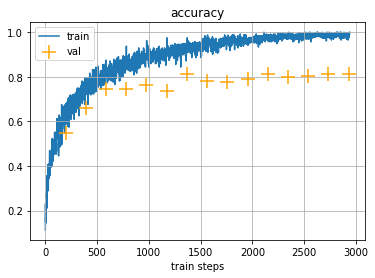

Current cccuracy is 0.8109375238418579
Final error: 18.91%
CPU times: user 8min 35s, sys: 4min 15s, total: 12min 50s
Wall time: 13min 4s


In [44]:
#!g1.1
%%time

model_no_mixup = ResNet18()
model_no_mixup.to(DEVICE)
opt = optim.SGD(model_no_mixup.parameters(), lr=0.1, momentum=0.9,
                      weight_decay=1e-4)
train(model_no_mixup, opt, 15, use_mixup=False)

Current cccuracy is 0.814648449420929
Best accuracy now is 0.814648449420929


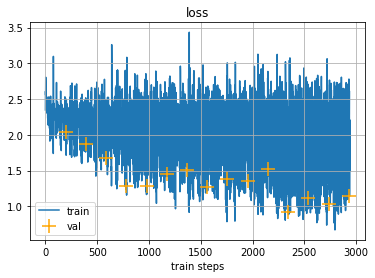

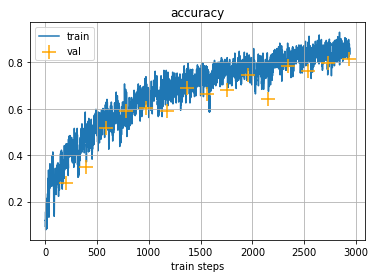

Final error: 18.54%
CPU times: user 8min 52s, sys: 4min 1s, total: 12min 54s
Wall time: 12min 51s


In [77]:
#!g1.1
%%time

model_mixup = ResNet18()
model_mixup.to(DEVICE)
opt = optim.SGD(model_mixup.parameters(), lr=0.1, momentum=0.9,
                      weight_decay=1e-4)
train(model_mixup, opt, 15, use_mixup=True)

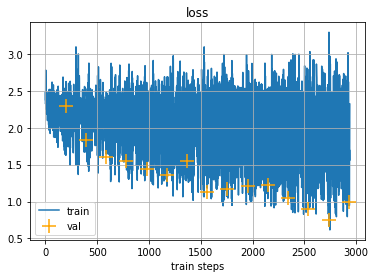

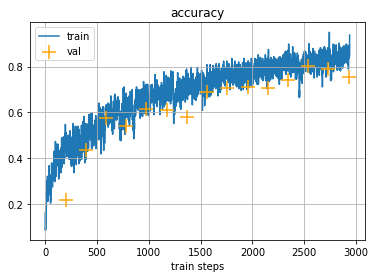

Current cccuracy is 0.7562500238418579
Final error: 24.37%
CPU times: user 8min 30s, sys: 4min 4s, total: 12min 35s
Wall time: 12min 32s


In [69]:
#!g1.1
%%time

model_cutmix = ResNet18()
model_cutmix.to(DEVICE)
opt = optim.SGD(model_cutmix.parameters(), lr=0.1, momentum=0.9,
                      weight_decay=1e-4)
train(model_cutmix, opt, 15, use_cutmix=True, use_mixup=False)

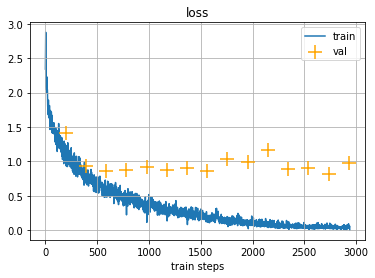

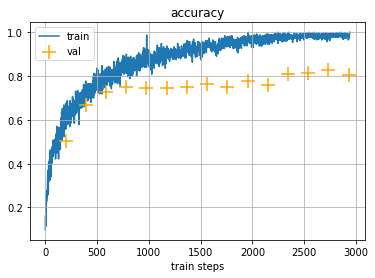

Current cccuracy is 0.8045898675918579
Final error: 19.54%
CPU times: user 8min 30s, sys: 4min 3s, total: 12min 33s
Wall time: 12min 29s


In [70]:
#!g1.1
%%time

model_cutout = ResNet18()
model_cutout.to(DEVICE)
opt = optim.SGD(model_cutout.parameters(), lr=0.1, momentum=0.9,
                      weight_decay=1e-4)
train(model_cutout, opt, 15, use_cutout=True, use_mixup=False)

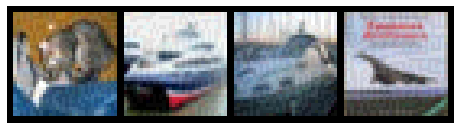

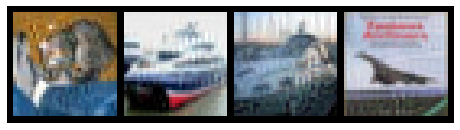

In [19]:
#!g1.1
import torchvision

def corrupt_sign(inputs, labels, model, weight):
    model.zero_grad()
    var_inputs = Variable(inputs, requires_grad=True)
    F.nll_loss(model(var_inputs), labels).backward()
    var_inputs = var_inputs + weight * torch.sign(var_inputs.grad)
    return torch.clamp(var_inputs, min=0, max=1)
    
    return corrupted_inputs

def corrupt_simple(inputs, labels, model, weight):
    model.zero_grad()
    var_inputs = Variable(inputs, requires_grad=True)
    F.nll_loss(model(var_inputs), labels).backward()
    var_inputs = var_inputs + weight * var_inputs.grad 
    return torch.clamp(var_inputs, min=0, max=1)

inputs, labels = iter(test_loader).next()
inputs = inputs[:4]
labels = labels[:4]
inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)

corrupted_inputs = corrupt_sign(inputs, labels, model_no_mixup, 0.03)
imshow(corrupted_inputs.data.cpu()) 

corrupted_inputs = corrupt_simple(inputs, labels, model_no_mixup, 0.1)
imshow(corrupted_inputs.data.cpu()) 

In [17]:
#!g1.1
def evaluate_network_attack(net, corrupt_function, weight, verbose=True):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data in test_loader:
        images, labels = data
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        images = corrupt_function(images, labels, net, weight)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).long().squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
    accuracy = (100. * sum(class_correct) / sum(class_total))
    if verbose:
        print('Accuracy %d %% \n' % (100. * sum(class_correct) / sum(class_total)))
        
        for i in range(10):
            print('Accuracy of %2s : %2d %%' % (
                i, 100. * class_correct[i] / class_total[i]))
    return accuracy

# Adversarial: no augmentation

In [20]:
#!g1.1
print('Without corruption:')
evaluate_network_attack(model_no_mixup, corrupt_sign, 0)
print('\n================\n')
print('With corruption:')
evaluate_network_attack(model_no_mixup, corrupt_sign, 0.03)

Without corruption:
Accuracy 83 % 

Accuracy of  0 : 93 %
Accuracy of  1 : 84 %
Accuracy of  2 : 84 %
Accuracy of  3 : 90 %
Accuracy of  4 : 76 %
Accuracy of  5 : 80 %
Accuracy of  6 : 66 %
Accuracy of  7 : 75 %
Accuracy of  8 : 76 %
Accuracy of  9 : 100 %


With corruption:
Accuracy 1 % 

Accuracy of  0 :  0 %
Accuracy of  1 :  0 %
Accuracy of  2 :  0 %
Accuracy of  3 :  0 %
Accuracy of  4 :  0 %
Accuracy of  5 :  0 %
Accuracy of  6 :  0 %
Accuracy of  7 :  0 %
Accuracy of  8 :  4 %
Accuracy of  9 : 11 %


1.875

# Adversarial: mixup

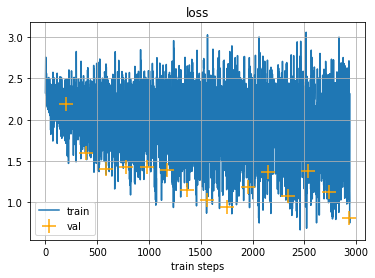

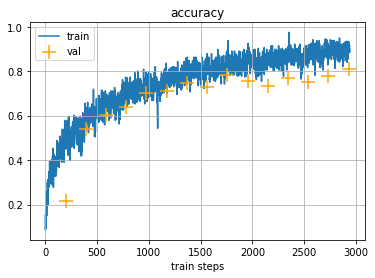

Current cccuracy is 0.8115234375
Best accuracy now is 0.8115234375
Final error: 18.85%
Accuracy 18 % 

Accuracy of  0 :  6 %
Accuracy of  1 : 30 %
Accuracy of  2 :  0 %
Accuracy of  3 :  4 %
Accuracy of  4 :  0 %
Accuracy of  5 :  0 %
Accuracy of  6 : 16 %
Accuracy of  7 :  8 %
Accuracy of  8 : 47 %
Accuracy of  9 : 52 %


In [38]:
#!g1.1
results = {}

for alpha in np.arange(0.1, 1.1, 0.1):
    model_mixup = ResNet18()
    model_mixup.to(DEVICE)
    opt = optim.SGD(model_mixup.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    train(model_mixup, opt, 15, use_mixup=True, alpha=alpha)
    acc = evaluate_network_attack(model_mixup, corrupt_sign, 0.03)
    results[alpha] = acc

In [39]:
for alpha, acc in results.items():
    print(f"Mixup. Alpha = {alpha}, accuracy = {acc}")

Mixup. Alpha = 0.1, accuracy = 15.0
Mixup. Alpha = 0.2, accuracy = 8.125
Mixup. Alpha = 0.30000000000000004, accuracy = 9.375
Mixup. Alpha = 0.4, accuracy = 19.375
Mixup. Alpha = 0.5, accuracy = 11.25
Mixup. Alpha = 0.6, accuracy = 7.5
Mixup. Alpha = 0.7000000000000001, accuracy = 14.375
Mixup. Alpha = 0.8, accuracy = 10.625
Mixup. Alpha = 0.9, accuracy = 15.625
Mixup. Alpha = 1.0, accuracy = 18.125


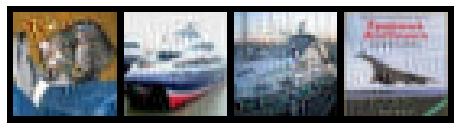

In [47]:
#!g1.1
inputs, labels = iter(test_loader).next()
inputs = inputs[:4]
labels = labels[:4]
inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)
corrupted_inputs = corrupt_simple(inputs, labels, model_no_mixup, 0.1)
imshow(corrupted_inputs.cpu().data) 

In [48]:
#!g1.1
evaluate_network_attack(model_no_mixup, corrupt_simple, 0.1)

Accuracy 66 % 

Accuracy of  0 : 75 %
Accuracy of  1 : 84 %
Accuracy of  2 : 69 %
Accuracy of  3 : 59 %
Accuracy of  4 : 46 %
Accuracy of  5 : 60 %
Accuracy of  6 : 66 %
Accuracy of  7 : 75 %
Accuracy of  8 : 61 %
Accuracy of  9 : 76 %


66.875

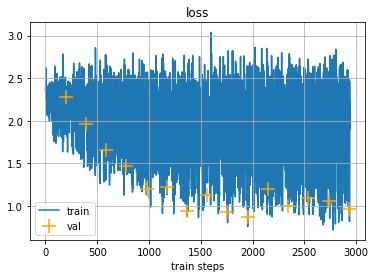

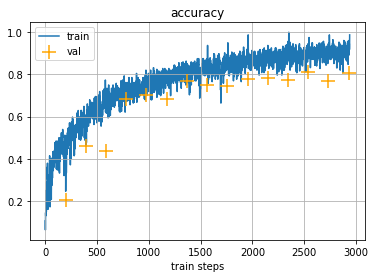

Current cccuracy is 0.806640625
Final error: 19.34%
Accuracy 80 % 

Accuracy of  0 : 81 %
Accuracy of  1 : 84 %
Accuracy of  2 : 92 %
Accuracy of  3 : 77 %
Accuracy of  4 : 53 %
Accuracy of  5 : 66 %
Accuracy of  6 : 77 %
Accuracy of  7 : 100 %
Accuracy of  8 : 90 %
Accuracy of  9 : 76 %
Mixup. Alpha = 0.1, accuracy = 68.75
Mixup. Alpha = 0.2, accuracy = 79.375
Mixup. Alpha = 0.30000000000000004, accuracy = 80.625
Mixup. Alpha = 0.4, accuracy = 75.625
Mixup. Alpha = 0.5, accuracy = 73.75
Mixup. Alpha = 0.6, accuracy = 73.125
Mixup. Alpha = 0.7000000000000001, accuracy = 80.625
Mixup. Alpha = 0.8, accuracy = 75.625
Mixup. Alpha = 0.9, accuracy = 71.875
Mixup. Alpha = 1.0, accuracy = 80.0


In [49]:
#!g1.1
results_simple = {}

for alpha in np.arange(0.1, 1.1, 0.1):
    model_mixup = ResNet18()
    model_mixup.to(DEVICE)
    opt = optim.SGD(model_mixup.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    train(model_mixup, opt, 15, use_mixup=True, alpha=alpha)
    acc = evaluate_network_attack(model_mixup, corrupt_simple, 0.1)
    results_simple[alpha] = acc
for alpha, acc in results_simple.items():
    print(f"Mixup. Alpha = {alpha}, accuracy = {acc}")

# Adversarial: cutmix

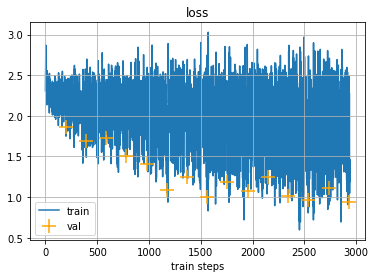

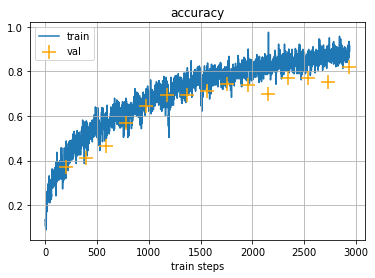

Current cccuracy is 0.819531261920929
Best accuracy now is 0.819531261920929
Final error: 18.05%
Accuracy 18 % 

Accuracy of  0 :  6 %
Accuracy of  1 : 38 %
Accuracy of  2 : 15 %
Accuracy of  3 :  4 %
Accuracy of  4 :  7 %
Accuracy of  5 :  0 %
Accuracy of  6 : 16 %
Accuracy of  7 :  8 %
Accuracy of  8 : 57 %
Accuracy of  9 : 17 %
Mixup. Alpha = 0.1, accuracy = 10.625
Mixup. Alpha = 0.2, accuracy = 14.375
Mixup. Alpha = 0.30000000000000004, accuracy = 11.875
Mixup. Alpha = 0.4, accuracy = 18.75
Mixup. Alpha = 0.5, accuracy = 15.0
Mixup. Alpha = 0.6, accuracy = 11.25
Mixup. Alpha = 0.7000000000000001, accuracy = 6.875
Mixup. Alpha = 0.8, accuracy = 13.125
Mixup. Alpha = 0.9, accuracy = 10.625
Mixup. Alpha = 1.0, accuracy = 18.125


In [71]:
#!g1.1
results_simple = {}

for alpha in np.arange(0.1, 1.1, 0.1):
    model_cutmix = ResNet18()
    model_cutmix.to(DEVICE)
    opt = optim.SGD(model_cutmix.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    train(model_cutmix, opt, 15, use_mixup=False, alpha=alpha, use_cutmix=True)
    acc = evaluate_network_attack(model_cutmix, corrupt_sign, 0.03)
    results_simple[alpha] = acc
for alpha, acc in results_simple.items():
    print(f"Mixup. Alpha = {alpha}, accuracy = {acc}")

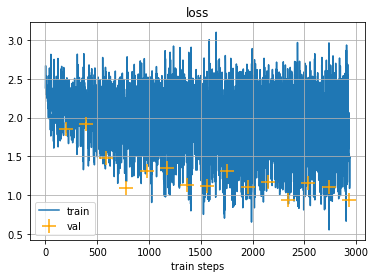

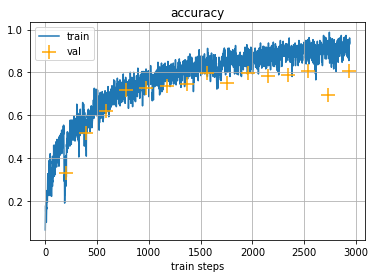

Current cccuracy is 0.806445300579071
Final error: 19.36%
Accuracy 79 % 

Accuracy of  0 : 75 %
Accuracy of  1 : 92 %
Accuracy of  2 : 76 %
Accuracy of  3 : 63 %
Accuracy of  4 : 76 %
Accuracy of  5 : 40 %
Accuracy of  6 : 88 %
Accuracy of  7 : 83 %
Accuracy of  8 : 100 %
Accuracy of  9 : 94 %
Mixup. Alpha = 0.1, accuracy = 72.5
Mixup. Alpha = 0.2, accuracy = 78.75
Mixup. Alpha = 0.30000000000000004, accuracy = 66.875
Mixup. Alpha = 0.4, accuracy = 75.625
Mixup. Alpha = 0.5, accuracy = 79.375
Mixup. Alpha = 0.6, accuracy = 76.875
Mixup. Alpha = 0.7000000000000001, accuracy = 74.375
Mixup. Alpha = 0.8, accuracy = 70.0
Mixup. Alpha = 0.9, accuracy = 82.5
Mixup. Alpha = 1.0, accuracy = 79.375


In [72]:
#!g1.1
results_simple = {}

for alpha in np.arange(0.1, 1.1, 0.1):
    model_cutmix = ResNet18()
    model_cutmix.to(DEVICE)
    opt = optim.SGD(model_cutmix.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    train(model_cutmix, opt, 15, use_mixup=False, alpha=alpha, use_cutmix=True)
    acc = evaluate_network_attack(model_cutmix, corrupt_simple, 0.1)
    results_simple[alpha] = acc
for alpha, acc in results_simple.items():
    print(f"Mixup. Alpha = {alpha}, accuracy = {acc}")

# Adversarial: cutout

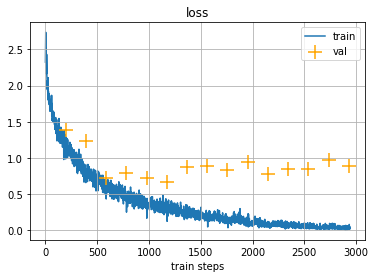

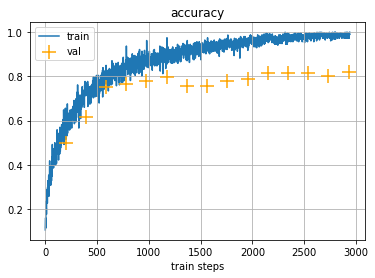

Current cccuracy is 0.818652331829071
Best accuracy now is 0.818652331829071
Final error: 18.13%
Accuracy 0 % 

Accuracy of  0 :  0 %
Accuracy of  1 :  0 %
Accuracy of  2 :  0 %
Accuracy of  3 :  0 %
Accuracy of  4 :  0 %
Accuracy of  5 :  0 %
Accuracy of  6 :  0 %
Accuracy of  7 :  0 %
Accuracy of  8 :  0 %
Accuracy of  9 :  5 %
Mixup. Alpha = 0.1, accuracy = 1.25
Mixup. Alpha = 0.2, accuracy = 3.125
Mixup. Alpha = 0.30000000000000004, accuracy = 4.375
Mixup. Alpha = 0.4, accuracy = 5.0
Mixup. Alpha = 0.5, accuracy = 4.375
Mixup. Alpha = 0.6, accuracy = 1.875
Mixup. Alpha = 0.7000000000000001, accuracy = 1.25
Mixup. Alpha = 0.8, accuracy = 2.5
Mixup. Alpha = 0.9, accuracy = 5.0
Mixup. Alpha = 1.0, accuracy = 0.625


In [73]:
#!g1.1
results_simple = {}

for alpha in np.arange(0.1, 1.1, 0.1):
    model_cutout = ResNet18()
    model_cutout.to(DEVICE)
    opt = optim.SGD(model_cutout.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    train(model_cutout, opt, 15, use_mixup=False, alpha=alpha, use_cutout=True)
    acc = evaluate_network_attack(model_cutout, corrupt_sign, 0.03)
    results_simple[alpha] = acc
for alpha, acc in results_simple.items():
    print(f"Mixup. Alpha = {alpha}, accuracy = {acc}")

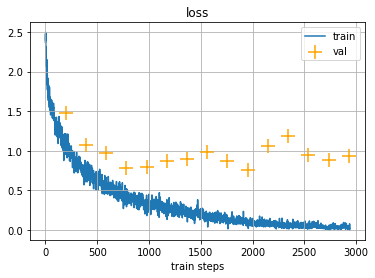

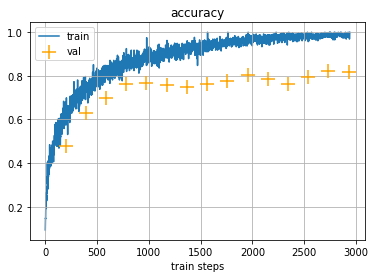

Current cccuracy is 0.8163086175918579
Final error: 18.37%
Accuracy 71 % 

Accuracy of  0 : 93 %
Accuracy of  1 : 92 %
Accuracy of  2 : 76 %
Accuracy of  3 : 59 %
Accuracy of  4 : 53 %
Accuracy of  5 : 66 %
Accuracy of  6 : 61 %
Accuracy of  7 : 50 %
Accuracy of  8 : 80 %
Accuracy of  9 : 82 %
Mixup. Alpha = 0.1, accuracy = 67.5
Mixup. Alpha = 0.2, accuracy = 71.875
Mixup. Alpha = 0.30000000000000004, accuracy = 70.625
Mixup. Alpha = 0.4, accuracy = 70.625
Mixup. Alpha = 0.5, accuracy = 73.75
Mixup. Alpha = 0.6, accuracy = 68.125
Mixup. Alpha = 0.7000000000000001, accuracy = 71.875
Mixup. Alpha = 0.8, accuracy = 73.75
Mixup. Alpha = 0.9, accuracy = 68.75
Mixup. Alpha = 1.0, accuracy = 71.875


In [74]:
#!g1.1
results_simple = {}

for alpha in np.arange(0.1, 1.1, 0.1):
    model_cutout = ResNet18()
    model_cutout.to(DEVICE)
    opt = optim.SGD(model_cutout.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    train(model_cutout, opt, 15, use_mixup=False, alpha=alpha, use_cutout=True)
    acc = evaluate_network_attack(model_cutout, corrupt_simple, 0.1)
    results_simple[alpha] = acc
for alpha, acc in results_simple.items():
    print(f"Mixup. Alpha = {alpha}, accuracy = {acc}")

In [ ]:
#!g1.1
